# Qubit-Resonator Design

Senario: We want to design a resonator coupled to a transmon. What kind of parameters need to be determined before drawing a mask

For the resonator, determine:
- $\omega_r$ : resonant (angular) frequency 
- $\kappa$ : linewidth of the resonance

Then calculate:
- $l$ : length of the resonator
- $C_c$ : coupling capacitance to the feedline.

For the transmon, determine:
- $f_{01}$ : qubit frequency
- $\alpha$ : anharmonicity
- $g$ : coupling strength between the resonator and transmon. 
- $\chi$: $\chi$ shift

Then calculate:
- $E_j$ : Josepthon energy
- $E_c$ : Charging energy
- $C_g$ : coupling capacitance between qubit island to the resonator
- $C_s$ : shunt capacitance across Josephson junction

Note on choosing parameters. $g$, $\chi$, $\kappa$, $\Delta$, $\omega_r$.

- For charge-sensitive qubit, small $E_j/E_c$. Charge dispersion and qubit frequency determine $E_j$ and $E_c$ uniquely.
- For a normal transmon, $E_j/E_c = 50-60$.There is a room for anharmoncity. It affects the tyep of gate operation, gate speed, etc.
- Depending on weak-dispersive ($\kappa \gg 2\chi$) vs strong-dispersive ($\kappa\ll2\chi$) vs intermediate regime (for high-fidelity measurement, $\kappa=2\chi$), $\chi$ and $\kappa$ are determined. $\chi=\left(\frac{g^2}{\Delta}\right)\cdot\left(\frac{\alpha}{\Delta+\alpha}\right)$.
- Put relation Qc vs Cc for capacitive and inductive coupling

# CPW, Resonator, Transmon

In [13]:
%matplotlib notebook
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, hbar, e, epsilon_0, c, mu_0
import pandas as pd

from transmonCPW import CPW, QuarterWaveResonator, Transmon

In [15]:
# readout cavity - quarterwave resonator
res = QuarterWaveResonator(w=10
                           , s=6
                           , h=500
                           , t=0.1
                           , epsilon_r=11.6                           
                           , metal='Nb'
                           , kinetic_induct_include=False
                           , w_r=6.2e9 * (2*pi)
                           , kappa=0.5e6 * (2*pi)
                          )

# Transmon
q = Transmon.in_GHz(Ej=12, Ec=0.30)
q.C_g = 3e-15

In [3]:
# find Ej and Ec, given f01 and anharmonicity

sol = q.find_Ej_Ec(4e9, -0.45e9)
(q.Ej, q.Ec) = sol

print(q.anharmonicity/1e6)
print(q.f01/1e9)
print(q.charge_dispersion/1e6)

In [16]:
# show all parameters

d = np.array([[q.Ej/1e9/h, q.Ec/1e6/h, q.Ej_to_Ec_ratio, q.charge_dispersion/1e3
               , q.f01/1e9, q.anharmonicity/1e6, q.g01(res)/2/pi/1e6
               , q.Chi01(res)/2/pi/1e6, q.Lj/1e-9, q.Ic/1e-9, q.total_cap/1e-15, (q.total_cap-q.C_g)/1e-15
               , q.C_g/1e-15, res.w_r/2/pi/1e9, res.resonator_length*1e3
               , res.Qc, res.kappa/2/pi/1e6, res.Z0, res.epsilon_eff, res.Mc /1e-12
               ,res.C_l/1e-12,res.Lm_l/1e-9, res.Lk_l/1e-9
              ]])
columns = ['Ej (GHz)', 'Ec (MHz)', 'Ej/Ec', 'charge disp. (kHz)', 'f01 (GHz)', 'anharm. (MHz)'
           , '$g/2\pi$ (MHz)', '$\chi/2\pi$ (MHz)', 'Lj (nH)','Ic (nA)','C_sigma (fF)'
           ,'C_sh (fF)','C_g (fF)','fr (GHz)','Res. Length (mm)','Qc'
           , '$\kappa/2\pi$ (MHz)', 'Z0 $(\Omega)$', '$\epsilon_{\rm re}$','Mc (pH)'
           ,'C_l (pH)', 'Lm_l (nH)','Lk_l (nH)' ]

df = pd.DataFrame(d.transpose(), index=columns, columns=['Values'])
df

,Values
Ej (GHz),12.000000
Ec (MHz),300.000000
Ej/Ec,40.000000
charge disp. (kHz),72.623174
f01 (GHz),5.046662
anharm. (MHz),-352.064231
$g/2\pi$ (MHz),54.880445
$\chi/2\pi$ (MHz),-0.120993
Lj (nH),13.621793
Ic (nA),24.160254


In [17]:
print(c/np.sqrt(res.epsilon_eff))
print(1/np.sqrt(res.Lm_l*res.C_l))

119444814.4358724
119444814.43587244


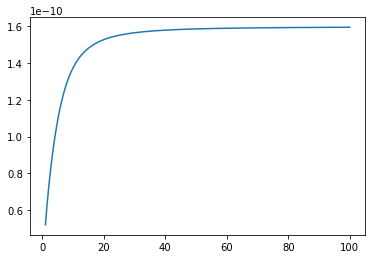

In [11]:
# plot C_l vs thickness of substrate

h_list = np.linspace(1, 100, 1000)
C_l_list = []
for h in h_list:
    res.h = h
    C_l_list.append(res.C_l)
    
plt.plot(h_list, C_l_list)

# Anharmonicity vs Ej/Ec for different N

In [3]:
Ej = 10
Ec = np.linspace(0.2,5, 100) 
Ec = np.logspace(-1, 1.5, 50)

Ns = [4, 6, 8, 10, 12]
qs = [Transmon.in_GHz(Ej=Ej,Ec=0, N=n) for n in Ns]
anharms = []

for q in qs:
    anh = np.array([])
    for E in Ec:
        q.Ec = E *1e9*h
        anh = np.append(anh, q.anharmonicity)
    anharms.append(anh)

# anharms

<IPython.core.display.Javascript object>


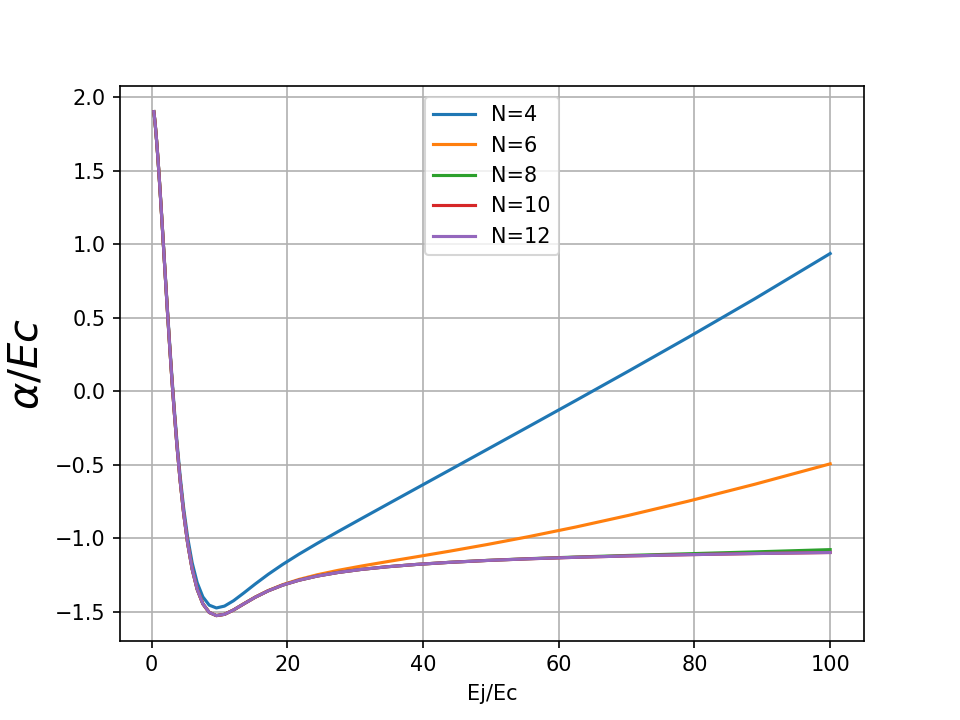

In [4]:
# import plotly
# import plotly.graph_objs as go
# from plotly.offline import iplot
# plotly.offline.init_notebook_mode(connected=True)

for anh in anharms:        
    plt.plot(Ej/Ec, anh/(Ec*1e9), '-')

plt.tick_params
plt.xlabel('Ej/Ec')
plt.ylabel(r'$\alpha/Ec$', fontsize=20)
plt.grid()
plt.legend([f'N={n}' for n in Ns])

# # iplot
# data = []
# for anh in anharms:
#     data.append(go.Scatter(x=Ej/Ec, y=anh/(Ec*1e9)))
    
# iplot({
#     "data": data,
#     "layout": go.Layout(title="Anharmoniciity vs Ej/Ec")
    
# })